In [1]:
# Import Packages:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
# Read files:
train = pd.read_csv('train.csv')
test = pd.read_csv('test_full.csv')

In [3]:
# Let's check the data:
test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
# Missing data analysis:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
# Data Type analysis:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Exploratory Data Analysis:  

### 'Ticket' Column:
Since there are a lot of Ticket duplicates we can assume that passengers that share the same ticket are friends or family. Let's make a new category for passengers that share ticket.

Because the data is separated to train and test, some passengers that appear in the trian data can be sharing a ticket with passengers in the test data. Therefore, only for this feature manipulation we will combine the 'Ticket' column from both train and test set in to one list, and then save only the ticket names that are duplicated. Than we will make a list of dup tickets for the train and test sats separately. It is maybe not the right way of data preprocessing, but we are not building the model based on the test predictions, and also the goal is to achieve the highest score.. 

In [6]:
# Extruct 'Ticket' column from train set 
Ticket_train = train.Ticket.tolist()
# Extruct 'Ticket' column from test set 
Ticket_test = test.Ticket.tolist()
# Combine both lists.
Ticket_total = Ticket_train + Ticket_test
# Make a list of shared tickets:
Ticket_total_Dup = set([x for x in Ticket_total if Ticket_total.count(x) > 1])
# Save to new list shared tickets that appear only in train set. 
Ticket_Dup_train = list(set(Ticket_train) & set(Ticket_total_Dup))
# Save to new list shared tickets that appear only in test set, later on. 
Ticket_Dup_test = list(set(Ticket_test) & set(Ticket_total_Dup))

In [7]:
# Add a new column for Shared ticket - Yes(1) or No(0)
train['Share_ticket'] = 0

# Create a mask for rows with shared ticket
mask2 = train['Ticket'].isin(Ticket_Dup_train)

# Apply mask on new column and assign 1 for shared ticket
train.loc[mask2,'Share_ticket'] = 1

### 'Title'  Column:

In [8]:
# From the 'Name' column we can extruct the Title of the passenger: 
train['Title'] = [row.split()[1] for row in train.Name]

# First we will change every Title that is not ['Mr.', 'Mrs.', 'Miss.', 'Master.'] in to 'M':
Mtitle = train.Title.value_counts() < 10
train.loc[train['Title'].map(Mtitle),'Title'] = 'M'

# We will calculate the average 'Age' for Miss. and Mrs. respectively
Miss_avg_age = train[train['Title'] == 'Miss.']['Age'].dropna().mean()
Mrs_avg_age = train[train['Title'] == 'Mrs.']['Age'].dropna().mean()

# Write a function that changes the value 'M' according to 'Sex':
# If male - change to 'Mr.', and if female - change to 'Mrs.' or 'Miss.' depends on the age.
def Change_title(df,row,i):
    if row == 'M':
        if df.iloc[i]['Sex'] == 'female':
            age = df.iloc[i]['Age']
            # If a woman age is closer to the average 'Miss.' age so assign 'Miss', else assign 'Mrs.':
            if abs(Miss_avg_age-age) < abs(Mrs_avg_age-age): 
                row = 'Miss.'
            else:
                row = 'Mrs.'    
            return(row)
        else:
            row = 'Mr.'
            return(row)
    else:
        return(row)

# Apply function on 'Title' column with list comprehension:
train['Title'] = [Change_title(train,row,i) for i, row in enumerate(train['Title'])]

### 'Cabin' Column:
The 'Cabin' column was full of NaN's and was really messy, the values were displayed as "Capital Letter"+"number". 
Since the number is not important, but the Cabin Letter is, we will first extruct the letters to a different column "Cabin_Class": 

In [9]:
def Class_L(row):
    if type(row) == str:
        row = row[0]
        return(row)
    else: 
        return(row) 

# Apply function on 'Cabin'
train['Cabin_Class'] = [Class_L(row) for row in train['Cabin']]

# A Class 'T' appeared only in one row, apparently becouse of typo. Let's change it to the most common Class within the 
# group of Pclass=1 - 'C':  
train['Cabin_Class'] = train['Cabin_Class'].replace('T','C')

### Columns Plotting:
Before dealing with the missing values problem in the data, les't first explore the columns in the data.

We will begin with displaying counterplots of the categorical columns of the data:

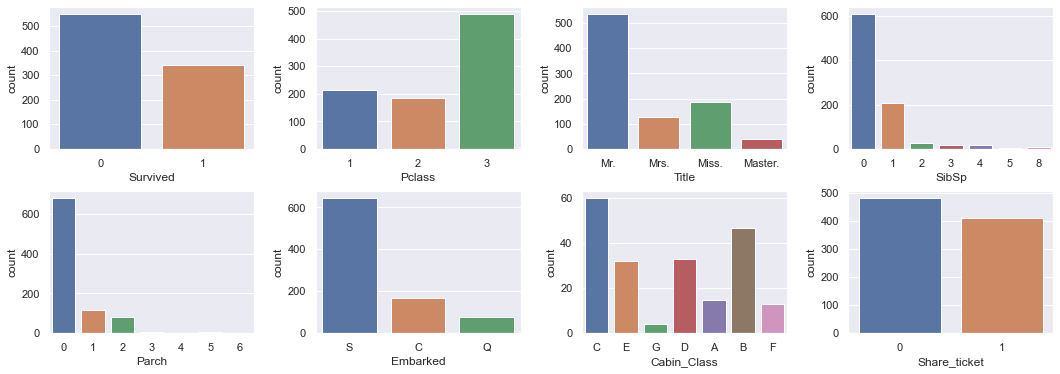

In [10]:
Cat_Columns = ['Survived','Pclass','Title','SibSp','Parch','Embarked','Cabin_Class','Share_ticket']
sns.set(style = "darkgrid")
fig = plt.figure(figsize = (18, 6))
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

for i ,col in enumerate(Cat_Columns):
    ax = fig.add_subplot(2, 4, i + 1)
    sns.countplot(x = col,data = train)

Some Insights: 
- We can clearly see that more passengers died then survived, most of the passengers stayed in the lower class (3), and most of the passengers embarked at 'S'.
- Since Mr. and Master. are related to males and Mrs. and Miss. are related to females, te is no need to plot the 'Sex' column.
- Both 'SibSp' and 'Parch' have values that count really low, there for we will later fix it by summing all values from 2-8 in 'SibSp' and 2-6 in 'Parch'. 

In [11]:
# Fixing the 'SibSp' and 'Parch' columns:
for col in ['Parch','SibSp']:
    train[col] = train[col].apply(lambda x: 2 if x > 2 else x)

### Missing Values Analysis in 'Cabin' 
We want to check if there is a correlation between passengers that reserved a ticket together ['Share_Ticket'] == 1, and if those passengers are sharing the same cabin, so for example, if the Anderson family (5 people) have the same ticket, do they 
also have the same cabin...
We will check it by looping over each group of passengers with the same ticket number, only on groups without missing values
(nans), and we'll calculate the number of times a group with the same ticket also shared the same cabin, and the number of times a group with the same ticket were scattered over different cabins.

This analysis will help us to understand how to impute the 'Cabin' missing values of passengers with the same ticket 
(['Share_Ticket'] == 1), So, therefore, if the above correlation exists, each group that shares the same ticket, and have
missing values in the 'Cabin' column, will be imputed with the same 'Cabin' value.

In [12]:
# Create a list of shared tickets: 
Tickets_Dup = train[train['Share_ticket'] == 1]['Ticket'].unique().tolist()

def Check_unique_Cabins(df,Tickets_Dup):
    
    Count = {
        'Unique Cabin' : 0,
        'Different Cabin' : 0
            }

    for ticket in Tickets_Dup:
        mask = df['Ticket'] == ticket
        Ticket_Group = df.loc[mask,'Cabin_Class']
        With_nan=Ticket_Group.isnull().values.sum()
        if With_nan == 0:
            a = len(Ticket_Group.unique())
            if a == 1:
                Count['Unique Cabin'] += 1
            elif a > 1:
                Count['Different Cabin'] += 1
    return(Count)    
print(Check_unique_Cabins(train,Tickets_Dup))

{'Unique Cabin': 61, 'Different Cabin': 2}


Ok, So we saw that there is a clear correlation between buying the same ticket and staying in the same cabin. 
Therefore, we are left with 3 different cases of missing data in the 'Cabin' column:

Case 1: Group of passengers with the same ticket number where some have a cabin value and some doesn't (missing values).
For those who doesn't have a cabin value we need to fill the missing values according to the cabin of the other passengers in the group.
In the rare case were there is more then one unique cabin for a group, we'll fill with the most frequent value. 

In [13]:
def Case_1(df,Tickets_Dup):
    #Loop over the shared ticket numbers: 
    for ticket in Tickets_Dup:
        mask = df['Ticket'] == ticket
        Ticket_grp = df.loc[mask,'Cabin_Class']
        # Count unique number of ticket in group:
        tot = len(Ticket_grp.unique())
        if tot > 1:
            # Check if there is nan in the group (but also other value...)
            tot_num = Ticket_grp.isnull().values.sum()
            if tot_num > 0:
                # Find the most frequent value that is not a nan:
                freq_val = Ticket_grp.value_counts().index[0]
                # replace nan in group with the most frequent value:
                df.loc[mask ,'Cabin_Class'] = df[mask]['Cabin_Class'].replace(np.nan,freq_val)
    return(df)

train = Case_1(train,Tickets_Dup)
print(Check_unique_Cabins(train,Tickets_Dup))

{'Unique Cabin': 71, 'Different Cabin': 2}


As we can see another 10 'Unique Cabin' where added as a result of filling the nan values in groups with other values also.  

We are now left with two cases, the second one refers to the shared ticket groups that their cabin is completly unknown, and the third group is passengers that bought thier ticket not in a group, and thier cabin is unknown as well. 
To impute thier missing cabin values we need first to check some correlation between the 'Cabin' column to the other columns in the data. 

To compute the correlations between other columns with categorical data, we will use the Chi squared test of independence.

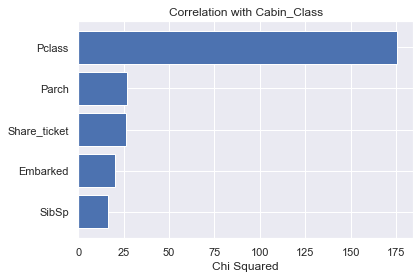

In [14]:
def Chi_sqrt(df,Columns,Col_def):   
    
    Chi_res = []
    Cabins = df[df.Cabin_Class.notna()]
    
    for col in Columns:
        crosstab = pd.crosstab(Cabins[Col_def], Cabins[col])
        chi2 = stats.chi2_contingency(crosstab)[0]
        Chi_res.append(chi2)
        
    zipped_lists = zip(Chi_res, Columns)
    sorted_zipped_lists = sorted(zipped_lists,reverse=False)
    Chi_res = [x for x,_  in sorted_zipped_lists]
    Columns = [x for _,x  in sorted_zipped_lists]
    
    sns.set(style = "darkgrid")
    fig, ax = plt.subplots()
    ax.barh(Columns,Chi_res)
    ax.set_yticklabels(Columns)
    ax.set_xlabel('Chi Squared')
    plt.title('Correlation with ' + Col_def)
    plt.show()
        
    

Columns = ['Pclass','SibSp','Parch','Embarked','Share_ticket']
Col_def = 'Cabin_Class'
Chi_sqrt(train,Columns,Col_def)

We can see that the 'Pclass' column has the most correlation between all the other categorical columns. Let's explore it:


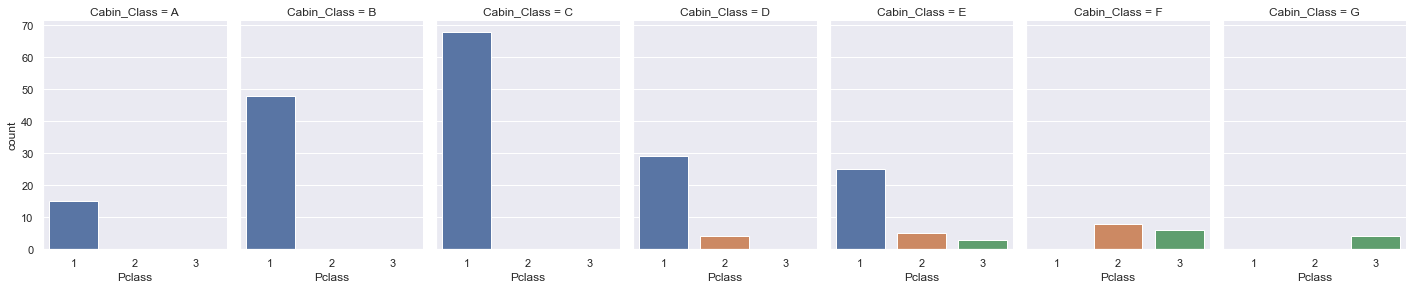

In [15]:
# Pclass distribution over different Cabins
train_Cabin_dropna = train.dropna(subset = ['Cabin_Class'])
sns.set(style = "darkgrid")
sns.catplot(x = "Pclass", col = "Cabin_Class",
                data = train_Cabin_dropna, kind = "count",
                height = 4, aspect = .7 ,col_order = ['A','B','C','D','E','F','G']);
plt.show()

# In the plot bellow we can see a counterplot that counts the number of Pclass apearance in each Cabin. 
# Remember, there is a lot of missing data.  

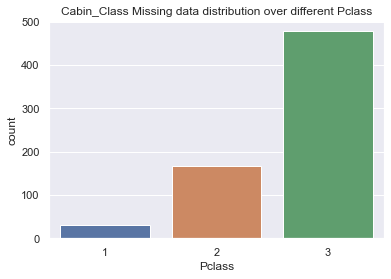

In [16]:
# Let's look at the distribution of the Cabin missing data over each Pclass:
train_Cabin_nan = train[train['Cabin_Class'].isnull()]
sns.set(style = "darkgrid")
sns.countplot(x = 'Pclass',data = train_Cabin_nan)
plt.title('Cabin_Class Missing data distribution over different Pclass')
plt.show()

# As we can see, most of the Cabin missing data belongs to the lower Pclass, we need to find a relevant way to estimate the
# missing data. 

Missing Values Replacement: We decided To fill the missing values in the 'Cabin_Class' column in the following way:

For each class of 'Pclass' (1/2/3) find the Cabin_Class values and thier apperence probabilities. Then, randomly assign 
classes to missing Cabin_Class values with the respective probabilities.

In [17]:
# Define the column that is to be imputed ['Cabin_Class'], and the column with the higer correlation that the probabiliteis
# will be computed from ['Pclass']
Col_with_nans = 'Cabin_Class'
Col_prob_from = 'Pclass'

# Create a Function that provides the lists of Cat values for each pclass and thier probabilities:
def Create_prob(df):
    # Column unique values (for Pclass is(1/2/3)):
    col_un = np.sort(df[Col_prob_from].unique().tolist())
    Cat_vals = {}
    Cat_vals_proba = {}
    for i in col_un:
        mask = df[Col_prob_from] == i
        # List of categorical values for each pclass group:
        lst = df.loc[mask,Col_with_nans].value_counts().index.tolist()
        # List of appearance for each value:
        n = np.array(df.loc[mask,Col_with_nans].value_counts().tolist())
        # Compute proba:
        prob = n / (sum(n))
        Cat_vals[i]=lst
        Cat_vals_proba[i]=prob
    return(Cat_vals,Cat_vals_proba)

Cat_Pclass,Cat_Pclass_proba = Create_prob(train)

Case 2: we need to fill one unique value to the group of passengers who have bought the same ticket:

In [18]:
# Create a function that randomly assigns Cabin_Class values by grouping Pclass value and according to their probabilities
# lists:   
Tickets_Dup2 = train[train.Cabin_Class.isna() & train.Share_ticket == 1]['Ticket'].unique().tolist()

def Case_2(df,Tickets_Dup2):
    #Loop over the shared ticken numbers: 
    for ticket in Tickets_Dup2:
        mask = df['Ticket'] == ticket
        Ticket_grp = df.loc[mask]
        # Count unique number of ticket in group:
        tot = len(Ticket_grp)
        # Obtaining the Pclass of the group:
        col_val = int(Ticket_grp['Pclass'].unique()) 
        val = str(np.random.choice(Cat_Pclass[col_val],1,p = Cat_Pclass_proba[col_val])[0])
        df.loc[mask,'Cabin_Class']=df[mask]['Cabin_Class'].replace(np.nan,val)   
    return(df)

train = Case_2(train,Tickets_Dup2)
print(Check_unique_Cabins(train,Tickets_Dup))

{'Unique Cabin': 198, 'Different Cabin': 2}


Case 3: Impute a random class to nan cabins for passengers that didn't buy the ticket as a group (['Share_ticket']==0). 
We will use the same permutation method used in case 2: 

In [19]:
# Create a function that randomly assigns Cabin_Class values by grouping Pclass value and according to their probabilities
# lists:  
def Assign_Cabin(row,i):
    if type(row) == float:
        pclass = train['Pclass'][i]
        row = str(np.random.choice(Cat_Pclass[pclass],1,p=Cat_Pclass_proba[pclass])[0])
    return(row)

train['Cabin_Class']=[Assign_Cabin(row,i) for i, row in enumerate(train['Cabin_Class'])] 

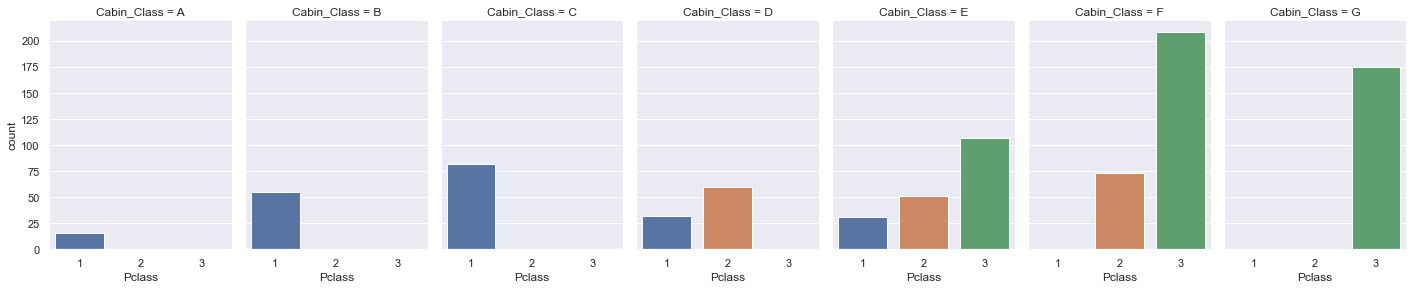

In [20]:
# Pclass distribution over different Cabins after Estimating missing values
sns.catplot(x="Pclass", col="Cabin_Class",
                data=train, kind="count",
                height=4, aspect=.7,col_order=['A','B','C','D','E','F','G'])
plt.show()

### 'Fare' Column:

C:\Users\odedb\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\odedb\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 7.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\odedb\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 31.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\odedb\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 55.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\odedb\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 79.9% of the points 

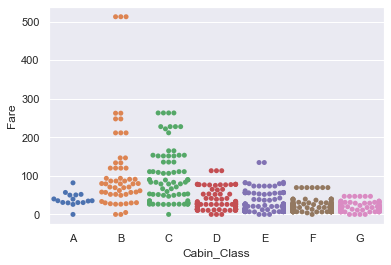

In [21]:
# Let's plot a swarmplot of the ticket price distribution ['Fare'] by each Cabin Class:
sns.swarmplot(x='Cabin_Class', y='Fare', data=train, order=['A','B','C','D','E','F','G'])
plt.show()

In [22]:
# As we can see, there is an outlier in Cabin B. It will be fixed by assigning to it a new value that equals to the mean of
# the other ticket prices in Cabin B, plus a 3 sigma. In this way it stays a high value but not an outlier. 
mask = train['Cabin_Class'] == 'B'
Cabin_Class_B = train[mask]
outlier = train[mask]['Fare'].max()
Avg = Cabin_Class_B[Cabin_Class_B['Fare'] < outlier]['Fare'].mean()
Std = Cabin_Class_B[Cabin_Class_B['Fare'] < outlier]['Fare'].std()
train['Fare'] = train['Fare'].replace(outlier, Avg + 3 * Std)

### 'Embarked' Column:

In [23]:
# Embarked column - There are 2 missing values, we will fill them with the most frequent value 'S':
train.Embarked.fillna('S',inplace = True)

### 'Age_col' Column:

In [24]:
# Fix ages less than one year to be one
babies = train['Age'] < 1
train.loc[babies, "Age"] = 1

In the 'Age' column there are many missing values aswell. We want to check for correlations between the categorical columns in the data. To do that we need first to transform these column to categorical by assigning the ages to bin ranges. We will call the new column 'Age_col'. After that, we will use the Chi-squared function to check for correlations.  

In [25]:
# Define ranges:
ranges = [*range(0,90,10)]
group_names = ['0-10','10-20', '20-30','30-40', '40-50', '50-60', '60-70','70-80']
# Create categorical Age group column
train['Age_col'] = pd.cut(train['Age'], bins = ranges, labels = group_names)

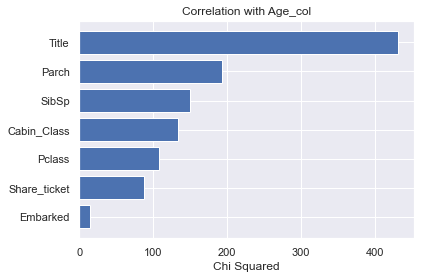

In [26]:
# Choosing categorical columns to comapre with:
Columns = ['Pclass','SibSp','Parch','Embarked','Share_ticket','Title','Cabin_Class']
Col_def = 'Age_col'
# Applying Chi-squared:
Chi_sqrt(train,Columns,Col_def)

We can see that 'Title' is highly correlated with 'Age_col', so we can impute the missing values with the probability imputer using the function 'Create_prob' to create the probabilities of the age according to the title. 

In [27]:
# Define the column that is to be imputed ['Age_col'], and the column with the higer correlation that the probabiliteis
# will be computed from ['Title']
Col_with_nans = 'Age_col'
Col_prob_from = 'Title'

# Convert 'Age_col' column from category to object - Create_prob function works better with object columns.
train.Age_col=train.Age_col.astype('object')

# Call the function and find probabilities: 
Cat_Title,Cat_Title_proba = Create_prob(train)

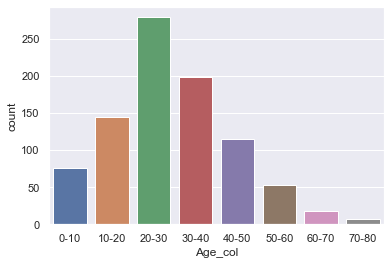

In [28]:
# Create a function that randomly assigns 'Age_col' values by grouping 'Title' value and according to their probabilities
# lists:  
  
def Assign_Age(df,row,i):
    if type(row) == float:
        title = df['Title'][i]
        row = str(np.random.choice(Cat_Title[title],1,p=Cat_Title_proba[title])[0])
    return(row)

train['Age_col']=[Assign_Age(train,row,i) for i, row in enumerate(train['Age_col'])]


# Let's plot a counterplot for the full imputer column - 'Age_col'
sns.countplot(x='Age_col',data=train , order=group_names)
plt.show()

### 'Age' column:
Impute the missing values of age by the mean value of existing values for each age group in 'Age_col'

In [29]:
# list of 'Age_col' values by order:
Age_ranges = list(np.sort(train.Age_col.unique()))

# Define a function that computes the mean value for each age group in 'Age_col'. Age_means is a dictionary with columns of 
# 'Age_col' and thier coresponding mean value to be assigned in 'Age' missing values.
def Age_mean(Age_ranges,df):
    Age_means = {}
    for age_bin in Age_ranges:
        Age_means[age_bin] = round(df[df['Age_col'] == age_bin]['Age'].mean()) 
    return(Age_means)
Age_means = Age_mean(Age_ranges,train)  

# Impute missing values:
train.loc[np.isnan(train['Age']),'Age'] =[Age_means[row['Age_col']] for i, row in train.iterrows() if np.isnan(row['Age'])]

### Continuous values with hist:

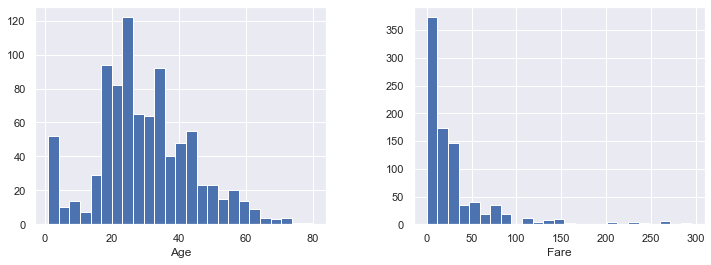

In [30]:
Cat_Columns = ['Age','Fare']
sns.set(style = "darkgrid")
fig = plt.figure(figsize = (12, 4))
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

for i ,col in enumerate(Cat_Columns):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.set_xlabel(col)
    plt.hist(x = col,data = train,bins = 25)
plt.show()

- 'Age' column is distributed close to normal - need scaling before modeling.
- 'Fare' column is more exponential distributed, it will need some feature engineering before modeling - Log transformation.

In [31]:
# Log transformation for Fare
log = PowerTransformer()
# Fit and Transform Log transformation:
log.fit(train[['Fare']])
train['Fare_log'] = log.transform(train[['Fare']])

# Scaler for scaling the Age column:
scaler = StandardScaler()
# Fit and transform Scaler:
scaler.fit(train[['Age']])
train['scaled_Age'] = scaler.transform(train[['Age']])

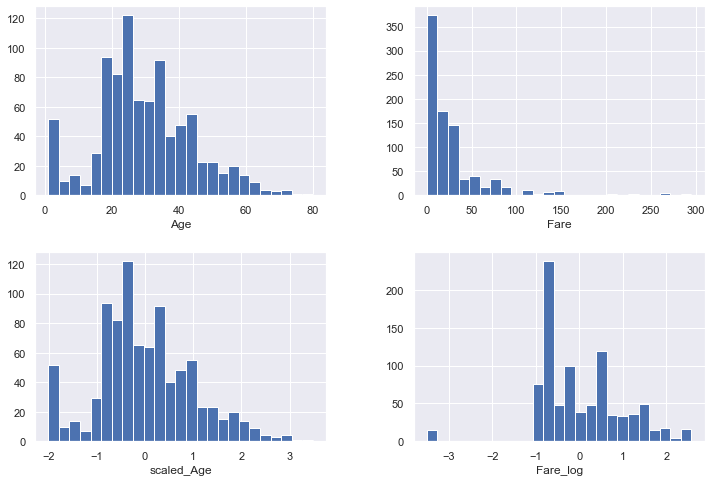

In [32]:
Cat_Columns = ['Age','Fare','scaled_Age','Fare_log']
sns.set(style = "darkgrid")
fig = plt.figure(figsize = (12, 8))
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

for i ,col in enumerate(Cat_Columns):
    ax = fig.add_subplot(2, 2, i + 1)
    ax.set_xlabel(col)
    plt.hist(x = col,data = train,bins = 25)
plt.show()

### Preproccesing the Test set:
Just before we start building a machine learning model to predict whether a passenger survived or not, we first need to apply the preproccesing transformations to the test set according what was done to the train set.  

In [33]:
# Missing data analysis:
test.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [34]:
# 'Ticket' column:

# Add a new column for Shared ticket - Yes(1) or No(0)
test['Share_ticket'] = 0

# Create a mask for rows with shared ticket
mask = test['Ticket'].isin(Ticket_Dup_test)

# Apply mask on new column and assign 1 for shared ticket
test.loc[mask,'Share_ticket'] = 1



# 'Title' column:

# From the 'Name' column we can extruct the Title of the passenger: 
test['Title'] = [row.split()[1] for row in test.Name]

# First we will change every Title that is not ['Mr.', 'Mrs.', 'Miss.', 'Master.'] in to 'M':
Mtitle = test.Title.value_counts() < 10
test.loc[test['Title'].map(Mtitle),'Title'] = 'M'

# We will use the average 'Age' of Miss. and Mrs. from what was calculated in the train set.
# Apply function on 'Title' column with list comprehension:
test['Title'] = [Change_title(test,row,i) for i, row in enumerate(test['Title'])]



# 'SibSp' and 'Parch' columns

# Fixing the 'SibSp' and 'Parch' columns:
for col in ['Parch','SibSp']:
    test[col] = test[col].apply(lambda x: 2 if x > 2 else x)

    
    
# 'Cabin_Class' column:

# Apply function on 'Cabin'
test['Cabin_Class'] = [Class_L(row) for row in test['Cabin']]

# Create a list of shared tickets: 
Tickets_Dup = test[test['Share_ticket'] == 1]['Ticket'].unique().tolist()

# Case 1: Imputing mising values according to the same cabin for passengers in a group:
test = Case_1(test,Tickets_Dup)

# Case 2: Randomly assigns Cabin_Class values by Pclass values and according to their probabilities lists for groups with shared
# ticket, and unknown cabin for all group:
Tickets_Dup2 = test[test.Cabin_Class.isna() & test.Share_ticket == 1]['Ticket'].unique().tolist()
test = Case_2(test,Tickets_Dup2)

# Case 3: Randomly assigns Cabin_Class values by Pclass values and according to their probabilities lists for lone passengers:
test['Cabin_Class'] = [Assign_Cabin(row,i) for i, row in enumerate(test['Cabin_Class'])] 



# 'Fare' column:

# Fill missing value by mean value:
test['Fare'] = test['Fare'].fillna(test['Fare'].mean())

# Log transformation for for scalling to normal prob:
test['Fare_log'] = log.transform(test[['Fare']])



# 'Age' & 'Age_col' column:

# Fix ages less than one year to be one
test.loc[babies, "Age"] = 1
# Create categorical Age group column
test['Age_col'] = pd.cut(test['Age'], bins = ranges, labels = group_names)
# Randomly assigns 'Age_col' values by grouping 'Title' value and according to their probabilities lists: 
test['Age_col'] = [Assign_Age(test,row,i) for i, row in enumerate(test['Age_col'])]
# Impute mean values per Age_col group for Age column: 
test.loc[np.isnan(test['Age']),'Age'] = [Age_means[row['Age_col']] for i, row in test.iterrows() if np.isnan(row['Age'])]

# Scaling transformation:
test['scaled_Age'] = scaler.transform(test[['Age']])

# Drop unused columns:
test.drop(['Ticket', 'Cabin' , 'Name','Sex' , 'Age_col','Fare' , 'Age'],inplace=True, axis=1)

In [35]:
# Drop unused columns:
train.drop(['Ticket', 'Cabin' , 'Name','Sex' , 'Age_col','Fare' , 'Age'],inplace=True, axis=1)

# View Final train set:
train.to_csv('train_clean.csv',index = False)
test.to_csv('test_clean.csv',index = False)
train

,PassengerId,Survived,Pclass,SibSp,Parch,Embarked,Share_ticket,Title,Cabin_Class,Fare_log,scaled_Age
0,1,0,3,1,0,S,0,Mr.,F,-0.881539,-0.547515
1,2,1,1,1,0,C,1,Mrs.,C,1.346257,0.565471
2,3,1,3,0,0,S,0,Miss.,G,-0.792974,-0.269268
3,4,1,1,1,0,S,1,Mrs.,C,1.073436,0.356786
4,5,0,3,0,0,S,0,Mr.,F,-0.777377,0.356786
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,0,S,0,Mr.,F,-0.297888,-0.199707
887,888,1,1,0,0,S,0,Miss.,B,0.528702,-0.756200
888,889,0,3,1,2,S,1,Miss.,E,0.288065,0.356786
889,890,1,1,0,0,C,0,Mr.,C,0.528702,-0.269268


In [36]:
test

,PassengerId,Survived,Pclass,SibSp,Parch,Embarked,Share_ticket,Title,Cabin_Class,Fare_log,scaled_Age
0,892,0,3,0,0,Q,0,Mr.,G,-0.805091,0.322006
1,893,1,3,1,0,S,0,Mrs.,C,-0.916364,1.191526
2,894,0,2,0,0,Q,0,Mr.,E,-0.592373,2.234951
3,895,0,3,0,0,S,0,Mr.,C,-0.704197,-0.199707
4,896,1,3,1,1,S,1,Mrs.,G,-0.354304,-0.547515
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,0,3,0,0,S,0,Mr.,E,-0.777377,2.374074
414,1306,1,1,0,0,C,1,Mrs.,C,1.728350,0.635033
415,1307,0,3,0,0,S,0,Mr.,F,-0.881539,0.600252
416,1308,0,3,0,0,S,0,Mr.,F,-0.777377,-0.338830
